In [1]:
import lime
from lime import lime_tabular
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import normalize
import seaborn as sns
import json
import math
import time
import ast
from IPython.display import clear_output
import os
import tensorflow as tf

In [2]:
# EDIT HERE FOR OTHER COURSES
data_path = '../easy-fail/'
week_type = 'eq_week'
feature_types = [ 'boroujeni_et_al', 
                 'chen_cui',  'lalle_conati', 
                 'marras_et_al']
course = 'dsp_001'
marras_et_al_id = feature_types.index('marras_et_al')
#akpinar_et_al_id = feature_types.index('akpinar_et_al')
remove_obvious = False

# Loading the features and their names

In [3]:
# function that replaces NaNs with the minimum of that feature over all weeks
def fillNaN(feature):
    shape = feature.shape
    feature_min = np.nanmin(
        feature.reshape(-1, shape[2]), axis=0
    )  # min of that feature over all weeks
    feature = feature.reshape(-1, shape[2])
    inds = np.where(np.isnan(feature))
    feature[inds] = np.take(feature_min.reshape(-1), inds[1])
    feature = feature.reshape(shape)
    return feature

In [4]:
# Loading the features
feature_list = {}

feature_type_list = []
for feature_type in feature_types:

    filepath = data_path + week_type + '-' + feature_type + '-' + course
    feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
    print(feature_current.shape)
    feature_norm = feature_current.reshape(-1,feature_current.shape[2] )
    print(feature_norm.shape)
    feature_type_list.append(pd.DataFrame(feature_norm))
feature_list[course] = feature_type_list

print('course: ', course)
print('week_type: ', week_type)
print('feature_type: ', feature_types)

(5611, 10, 3)
(56110, 3)
(5611, 10, 13)
(56110, 13)
(5611, 10, 22)
(56110, 22)
(5611, 10, 7)
(56110, 7)
course:  dsp_001
week_type:  eq_week
feature_type:  ['boroujeni_et_al', 'chen_cui', 'lalle_conati', 'marras_et_al']


In [5]:
# Loading feature names
feature_names= dict()

for feature_type in feature_types:
    
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/settings.txt'
    file = open(filepath, "r")
    contents = file.read()
    dictionary = ast.literal_eval(contents)
    file.close()
    
    feature_type_name = dictionary['feature_names']
    if feature_type == 'akpinar_et_al':
        akp_mask = np.where(np.isin(feature_type_name, 
                 ["TotalClicks", "NumberSessions", "Time-video-sum", "Time-problem-sum",
                  'problem.check-problem.check-problem.check', 
                  'problem.check-problem.check-video.load', 
                  'video.play-video.play-video.play',
                  'video.play-video.pause-video.load',
                  'video.play-problem.check-problem.check',
                  'video.play-video.stop-video.play',
                  'video.pause-video.speedchange-video.play',
                  'video.stop-video.play-video.seek',
                  'video.stop-problem.check-video.load']))
        print(akp_mask)
        feature_type_name = list(np.array(feature_type_name)[akp_mask[0]])
        feature_list[course][akpinar_et_al_id] = feature_list[course][akpinar_et_al_id][akp_mask[0]]
        
    feature_names[feature_type] = feature_type_name
    print(feature_type, len(feature_type_name))

if remove_obvious: 
    # drop 'student shape', 'competency strength', 'competency alignment' in marras at al
    
    mask = np.where(np.isin(feature_names['marras_et_al'], 
                 ['student_shape', 'competency_strength', 'competency_alignment']))
    
    new_marras = np.delete(np.array(feature_names['marras_et_al']), mask[0])
    feature_names['marras_et_al'] = new_marras
    
    new_features = feature_list[course][marras_et_al_id].drop(mask[0], axis=1)
    feature_list[course][marras_et_al_id] = new_features


boroujeni_et_al 3
chen_cui 13
lalle_conati 22
marras_et_al 7


In [6]:
# reformat feature names
# ex: time_sessions_<function sum at 0x7f3bd02cc9d0> -> time_sessions_sum
def clean_name(feature):
    id = feature.find('<')
    if id==-1:
        return feature
    fct = feature[id+9:id+14].strip()
    return feature[0:id]+fct


for k in feature_names.keys():
    cleaned = [clean_name(x) for x in feature_names[k]]
    feature_names[k] = cleaned


In [7]:
def load_labels(course):
    feature_type = "boroujeni_et_al"
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/feature_labels.csv'
    labels = pd.read_csv(filepath)['label-pass-fail']
    labels[labels.shape[0]] = 1
    return labels.values

In [8]:
# TO CHANGE HERE THE WEEKS NUMBER
overwrite_num_weeks = 5

In [9]:
def load_labels(course):
    feature_type = "boroujeni_et_al"
    filepath = data_path + week_type + '-' + feature_type + '-' + course + '/feature_labels.csv'
    labels = pd.read_csv(filepath)['label-pass-fail']
    labels[labels.shape[0]] = 1
    return labels.values

def load_features(course, overwrite_num_weeks):
    feature_list = []
    selected_features = []
    total_features = set()
    num_weeks = 0
    num_features = 0
    for i,feature_type in enumerate(feature_types):
        filepath = data_path + week_type + '-' + feature_type + '-' + course 
        feature_current = np.load(filepath+'/feature_values.npz')['feature_values']
        
        shape = feature_current.shape
#         print(shape)

        if remove_obvious and feature_type=='marras_et_al':
            feature_current = np.delete(feature_current, mask[0], axis=2)
        
        if feature_type=='akpinar_et_al':
            akp_mask_dl = np.delete(list(range(shape[2])), akp_mask[0])
            feature_current = np.delete(feature_current, akp_mask_dl, axis=2)
        
        shape = feature_current.shape
        print(shape)
        if i==0:
            num_weeks = shape[1]
            num_weeks=overwrite_num_weeks
        
        
        selected = np.arange(shape[2])
        # drop existed features
        exist_mask = []
        for i, name in enumerate(feature_names[feature_type]):
            if name in total_features:
                exist_mask.append(i)
            else:
                total_features.add(name)
        feature_current = np.delete(feature_current, exist_mask, axis=2)
        selected = np.delete(selected, exist_mask)
        
        nonNaN = (shape[0]*shape[1] - np.isnan(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0) > 0)
        feature_current = feature_current[:,:,nonNaN]
        selected = selected[nonNaN]
        feature_current = fillNaN(feature_current)
        nonZero = (abs(feature_current.reshape(-1,feature_current.shape[2])).sum(axis=0)>0)
        selected = selected[nonZero]
        feature_current = feature_current[:,:overwrite_num_weeks,nonZero]
#       print(len(feature_names[feature_type]), selected)
        selected_features.append(np.array(feature_names[feature_type])[[selected]])
        num_features += len(np.array(feature_names[feature_type])[[selected]])


        ##### Normalization with min-max. Added the artifical 1.001 max row for solving the same min max problem
        ##### for features with max=0 I added 1 instead of 1.001 of maximum

        features_min = feature_current.min(axis=0).reshape(-1)
        features_max = feature_current.max(axis=0)
        features_max = np.where(features_max==0,np.ones(features_max.shape),features_max)
        max_instance = 1.001*features_max
        feature_current = np.vstack([feature_current,max_instance.reshape((1,)+max_instance.shape)])
        features_max = features_max.reshape(-1)
        feature_norm = (feature_current.reshape(shape[0]+1,-1)-features_min)/(1.001*features_max-features_min)
        feature_current = feature_norm.reshape(-1,feature_current.shape[1],feature_current.shape[2] )
        
        num_features += feature_current.shape[2]
        print(num_features)
        
        feature_list.append(feature_current)
        
    features = np.concatenate(feature_list, axis=2)
    features_min = features.min(axis=0).reshape(-1)
    features_max = features.max(axis=0)
    features = features.reshape(features.shape[0],-1)
    features = pd.DataFrame(features)
    
    SHAPE = features.shape
    # print(np.isnan(features[0,0,-1]))
    print('features shape:', features.shape)
    print('course: ', course)
    print('week_type: ', week_type)
    print('feature_type: ', feature_types)
    print(selected_features)
    return features, features_min, features_max, selected_features, overwrite_num_weeks, num_features

In [10]:
y = load_labels(course)

In [11]:
features, features_min, features_max, selected_features, num_weeks, num_features = load_features(course, overwrite_num_weeks)

(5611, 10, 3)
4
(5611, 10, 13)
18
(5611, 10, 22)
24
(5611, 10, 7)
32
features shape: (5612, 140)
course:  dsp_001
week_type:  eq_week
feature_type:  ['boroujeni_et_al', 'chen_cui', 'lalle_conati', 'marras_et_al']
[array([['regularity_peak_dayhour', 'regularity_periodicity_m1',
        'delay_lecture']], dtype='<U25'), array([['total_clicks', 'number_sessions', 'time_sessions_sum',
        'time_sessions_mean', 'time_between_sessions_std',
        'time_sessions_std', 'total_clicks_weekday',
        'total_clicks_weekend', 'ratio_clicks_weekend_day',
        'total_clicks_video', 'total_clicks_problem',
        'time_in__problem_sum', 'time_in__video_sum']], dtype='<U25'), array([['total_clicks_Video.Load', 'weekly_prop_watched_mean',
        'weekly_prop_replayed_mean', 'total_clicks_Video',
        'frequency_action_Video.Load']], dtype='<U35'), array([['competency_strength', 'competency_alignment',
        'competency_anticipation', 'content_alignment',
        'content_anticipation'

In [12]:
num_features

32

In [13]:
features.shape

(5612, 140)

In [14]:
type(features)

pandas.core.frame.DataFrame

In [15]:
# calculate the number of features
n_features = sum([len(x) for x in selected_features])

In [16]:
n_features

4

In [17]:
feature_dict = dict()
for i, feature_type in enumerate(feature_types):
    feature_dict[feature_type] = list(selected_features[i])
    
selected_features = feature_dict
# print(selected_features)
# file = 'selected_features/' + course + '_after.json'
# with open(file, 'w') as f: 
#     json.dump(selected_features, f)

In [18]:
num_feature_type = []
for feature_type in feature_types:
    num_feature_type.append(len(selected_features[feature_type]))
print(num_feature_type)

[1, 1, 1, 1]


In [19]:
# Loading feature names and transforming them to 2D format.
feature_names = []
final_features = []
for i,feature_type in enumerate(feature_types):
    [final_features.append(x) for x in selected_features[feature_type]]

In [20]:
flat_final_features = [item for sublist in final_features for item in sublist]
print(final_features)
print(type(final_features))
print(type(num_weeks))

[array(['regularity_peak_dayhour', 'regularity_periodicity_m1',
       'delay_lecture'], dtype='<U25'), array(['total_clicks', 'number_sessions', 'time_sessions_sum',
       'time_sessions_mean', 'time_between_sessions_std',
       'time_sessions_std', 'total_clicks_weekday',
       'total_clicks_weekend', 'ratio_clicks_weekend_day',
       'total_clicks_video', 'total_clicks_problem',
       'time_in__problem_sum', 'time_in__video_sum'], dtype='<U25'), array(['total_clicks_Video.Load', 'weekly_prop_watched_mean',
       'weekly_prop_replayed_mean', 'total_clicks_Video',
       'frequency_action_Video.Load'], dtype='<U35'), array(['competency_strength', 'competency_alignment',
       'competency_anticipation', 'content_alignment',
       'content_anticipation', 'student_speed', 'student_shape'],
      dtype='<U23')]
<class 'list'>
<class 'int'>


In [21]:
for i in np.arange(num_weeks):
    feature_type_name_with_weeks = [(x+'_InWeek'+str(i+1)) for x in flat_final_features]
    feature_names.append(feature_type_name_with_weeks)
feature_names = np.concatenate(feature_names, axis=0)
feature_names = feature_names.reshape(-1)
print(feature_names)
features.columns = feature_names

['regularity_peak_dayhour_InWeek1' 'regularity_periodicity_m1_InWeek1'
 'delay_lecture_InWeek1' 'total_clicks_InWeek1' 'number_sessions_InWeek1'
 'time_sessions_sum_InWeek1' 'time_sessions_mean_InWeek1'
 'time_between_sessions_std_InWeek1' 'time_sessions_std_InWeek1'
 'total_clicks_weekday_InWeek1' 'total_clicks_weekend_InWeek1'
 'ratio_clicks_weekend_day_InWeek1' 'total_clicks_video_InWeek1'
 'total_clicks_problem_InWeek1' 'time_in__problem_sum_InWeek1'
 'time_in__video_sum_InWeek1' 'total_clicks_Video.Load_InWeek1'
 'weekly_prop_watched_mean_InWeek1' 'weekly_prop_replayed_mean_InWeek1'
 'total_clicks_Video_InWeek1' 'frequency_action_Video.Load_InWeek1'
 'competency_strength_InWeek1' 'competency_alignment_InWeek1'
 'competency_anticipation_InWeek1' 'content_alignment_InWeek1'
 'content_anticipation_InWeek1' 'student_speed_InWeek1'
 'student_shape_InWeek1' 'regularity_peak_dayhour_InWeek2'
 'regularity_periodicity_m1_InWeek2' 'delay_lecture_InWeek2'
 'total_clicks_InWeek2' 'number_sess

In [22]:
features.shape

(5612, 140)

In [23]:
features.to_csv(f"{course}_features_5_weeks.csv", index=False)

In [24]:
# This block loads number of features in each feature set.
num_feature_type = []
for i,feature_type in enumerate(feature_types):
    num_feature_type.append(len(selected_features[feature_type][0]))
print(num_feature_type)


[3, 13, 5, 7]


# Making a predict_proba

In [25]:
# This module transforms our data to the 2D format biLSTM was trained with.
def transform_x(x, num_feature_type, num_weeks, features_min, features_max):
    x = np.array(x)
    num_feature_type = np.array(num_feature_type)
    num_features = num_feature_type.sum()
    x = x.reshape((-1, num_weeks, num_features))
    shape = x.shape
    features_max = np.where(
        features_max == 0, np.ones(features_max.shape), features_max
    )
    max_instance = 1.001 * features_max
    feature_current = np.vstack([x, max_instance.reshape((1,) + max_instance.shape)])
    features_max = features_max.reshape(-1)
    feature_norm = (feature_current.reshape(shape[0] + 1, -1) - features_min) / (
        1.001 * features_max - features_min
    )
    x = feature_norm[: feature_norm.shape[0] - 1, :]
    return x

In [26]:
print(features.shape)
# EDIT HERE FOR OTHER MODELS
model_path = 'models/'
model_name = model_path + "lstm_bi_"+ course + "_" + str(overwrite_num_weeks) + "_weeks"

# Original
loaded_model=keras.models.load_model(model_name)

#loaded_model=tf.saved_model.load("models/lstm_bi_dsp_001_1710780636.1417_3_weeks_test.keras")


(5612, 140)


2024-07-23 10:25:51.480041: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-23 10:25:51.480061: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-23 10:25:51.480066: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-23 10:25:51.480105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-23 10:25:51.480133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-23 10:25:52.337179: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outpu

In [27]:
config = loaded_model.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"])

(None, 140)


In [28]:
# This lambda returns a (NUM OF INSTANCES,2) array of prob of pass in first column and prob of fail in another column
# This lambda returns a (NUM OF INSTANCES,2) array of prob of pass in first column and prob of fail in another column
predict_fn = lambda x: np.array(
    [[1-loaded_model.predict(transform_x(x,num_feature_type,num_weeks,features_min,features_max))],
     [loaded_model.predict(transform_x(x,num_feature_type,num_weeks,features_min,features_max))]]).reshape(2,-1).T


## Creating a LIME tabular explainer for the Loaded features 

In [29]:
def show_all_in_notebook(explainers,instances,real_labels,features,num_weeks,num_feature_type,group):
    for i,exp in enumerate(explainers):
        print("For instance number {i:d} the explanation is as follows:".format(i=instances[i]))
        s = 'fail' if real_labels[instances[i]] else 'pass'
        print("The real label for this instance is {}".format(s))
        p = predict_fn(features[instances[i],:])
        s = 'fail' if p[0,1]>0.5 else 'pass'
        print('The model predicted label for this instance is {} ({:.2f})'.format(s,max(p[0,:])))
        exp.show_in_notebook()
        h = exp.as_html()
        if (group == 'r'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/RandomPick/notebookExps/'):
                os.makedirs('./uniform_eq_results_ori/LIME/RandomPick/notebookExps/')
            Html_file= open("./uniform_eq_results_ori/LIME/RandomPick/notebookExps/"+str(instances[i])+".html","w")
            Html_file.write(h)
            Html_file.close()
        elif (group == 's'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/SubmodularPick/notebookExps/'):
                os.makedirs('./uniform_eq_results_ori/LIME/SubmodularPick/notebookExps/')
            Html_file= open("./uniform_eq_results_ori/LIME/SubmodularPick/notebookExps/"+str(instances[i])+".html","w")
            Html_file.write(h)
            Html_file.close()
        else:
            if not os.path.exists('./uniform_eq_results_ori/LIME/notebookExps/'):
                os.makedirs('./uniform_eq_results_ori/LIME/notebookExps/')
            Html_file= open("./uniform_eq_results_ori/LIME/notebookExps/"+str(instances[i])+".html","w")
            Html_file.write(h)
            Html_file.close()
    return

In [30]:
def pyplot_all(explainers,instances,real_labels,group):
    import matplotlib.pyplot as plt

    for i,exp in enumerate(explainers):
        s='fail' if real_labels[instances[i]] else 'pass'
        label=exp.available_labels()[0]
        expl = exp.as_list(label=label)
        fig = plt.figure(facecolor='white')
        vals = [x[1] for x in expl]
        names = [x[0] for x in expl]
#         print(i,vals, names)
        
        vals.reverse()
        names.reverse()
        colors = ['green' if x > 0 else 'red' for x in vals]
        pos = np.arange(len(expl)) + .5
        
        plt.barh(pos, vals, align='center', color=colors)
        plt.yticks(pos, names)
        if exp.mode == "classification":
            title = 'Local explanation for class %s for instance %d with real class %s' % (exp.class_names[label],instances[i],s)
        else:
            title = 'Local explanation'
        plt.title(title)
        
        if (group == 'r'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/RandomPick/pyplots/'):
                os.makedirs('./uniform_eq_results_ori/LIME/RandomPick/pyplots/')
            plt.savefig("./uniform_eq_results_ori/LIME/RandomPick/pyplots/"+str(instances[i])+".png", bbox_inches = 'tight', facecolor=fig.get_facecolor())
        elif (group == 's'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/SubmodularPick/pyplots/'):
                os.makedirs('./uniform_eq_results_ori/LIME/SubmodularPick/pyplots/')
            plt.savefig("./uniform_eq_results_ori/LIME/SubmodularPick/pyplots/"+str(instances[i])+".png", bbox_inches = 'tight', facecolor=fig.get_facecolor())
        else:
            if not os.path.exists("./uniform_eq_results_ori/LIME/" +course + "/pyplots/"):
                os.makedirs("./uniform_eq_results_ori/LIME/" +course + "/pyplots/")
            plt.savefig("./uniform_eq_results_ori/LIME/" +course + "/pyplots/"+str(instances[i])+".png", bbox_inches = 'tight', facecolor=fig.get_facecolor())
    return
                            

In [31]:
def DataFrame_all(explainers,instances,real_labels,group):
    df=pd.DataFrame({})
    class_names=['pass', 'fail']
    dfl=[]
    for i,exp in enumerate(explainers):
        this_label=exp.available_labels()[0]
        l=[]
        l.append(("exp number",instances[i]))
        l.append(("real value",'fail' if real_labels[instances[i]] else 'pass'))
        l.extend(exp.as_list(label=this_label))
        dfl.append(dict(l))
    df=pd.DataFrame(dfl)
    dfl=[pd.DataFrame.from_dict(x, orient='index') for x in dfl]
    for i,x in enumerate(dfl):
        if (group == 'r'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/RandomPick/dataframes/'):
                os.makedirs('./uniform_eq_results_ori/LIME/RandomPick/dataframes/')
            x.to_csv(r"./uniform_eq_results_ori/LIME/RandomPick/dataframes/"+str(instances[i])+'.csv')
        elif (group == 's'):
            if not os.path.exists('./uniform_eq_results_ori/LIME/SubmodularPick/dataframes/'):
                os.makedirs('./uniform_eq_results_ori/LIME/SubmodularPick/dataframes/')
            x.to_csv(r"./uniform_eq_results_ori/LIME/SubmodularPick/dataframes/"+str(instances[i])+'.csv')
        else:
            if not os.path.exists("./uniform_eq_results_ori/LIME/" + course + "/dataframes/"):
                os.makedirs("./uniform_eq_results_ori/LIME/" + course + "/dataframes/")
            x.to_csv(r"./uniform_eq_results_ori/LIME/" + course + "/dataframes/"+str(instances[i])+'.csv')
    # for x in dfl:
    #     display(x.head(len(instances)))
    return df,dfl


# LIME training

In [32]:
group = 'UniformPick'
single_student=features.iloc[0].values
type(single_student)
example = single_student.reshape(1, -1)
example.shape
prediction = loaded_model.predict(example)
prediction

2024-07-23 10:26:03.384412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-23 10:26:03.800182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-23 10:26:03.860318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-23 10:26:03.993765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-07-23 10:26:04.053579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.00271773]], dtype=float32)

In [33]:
def get_student_ids_from_indices(indices, course):
    # Load the mapping file
    mapping = pd.read_csv(f"data/user_id_mapping-{course}.csv")
    
    # Filter the DataFrame based on the indices
    filtered_mapping = mapping.iloc[indices]
    
    # Get the user_ids corresponding to the provided indices
    student_ids = filtered_mapping['user_id'].tolist()
    
    return student_ids

In [34]:
def get_indices_from_student_ids(student_ids, course):
    # Load the mapping file
    mapping = pd.read_csv(f"data/user_id_mapping-{course}.csv")
    
    # Filter the DataFrame based on the user_id values in student_ids
    filtered_mapping = mapping[mapping['user_id'].isin(student_ids)]
    
    # Get the indices and save them as a new list
    indices = filtered_mapping.index.tolist()
    
    return indices


In [109]:
# samples_id=pd.read_csv("data/"+str(course) + "_sample_5.csv")

# # Select only the "user_id" column
# samples = np.array(samples_id['user_id'])
# samples

# # Load the mapping file
# mapping = pd.read_csv("data/user_id_mapping-"+str(course)+".csv")

# # Filter the DataFrame based on the user_id values in instances
# filtered_mapping = mapping[mapping['user_id'].isin(samples)]

# # Get the indices and save them as a new list
# instances = filtered_mapping.index.tolist()
# instances

[5192, 6478, 8286, 9749, 13359]

In [35]:
############################################## CODE TO GET THE INDICES OF THE FEATURES
# I pick any feature set here and take the indices that are not easy fail
index=pd.read_csv("../easy-fail/eq_week-chen_cui-" + str(course) + "/feature_labels.csv",)
index

# Make the index a column called 'feature_index'
index.reset_index(inplace=True)
index.rename(columns={'index': 'feature_index'}, inplace=True)

# Rename 'Unnamed: 0' to 'original_index'
index.rename(columns={'Unnamed: 0': 'original_index'}, inplace=True)

# Remove the other columns except 'feature_index' and 'original_index'
index = index[['feature_index', 'original_index']]

samples_id=pd.read_csv("data/"+str(course) + "_sample_5.csv")
samples_id

# USE THIS INDEX MAPPING TO GET THE INDEX IN THE FEATURES
index_mapping = dict(zip(index['original_index'], index['feature_index']))
index_mapping

samples_id=pd.read_csv("data/"+str(course) + "_sample_5.csv")

samples_id['feature_index'] = samples_id['original_index'].map(index_mapping)

instances=samples_id['feature_index'].values
assert np.all(instances < features.shape[0])

FileNotFoundError: [Errno 2] No such file or directory: 'data/dsp_001_sample_5.csv'

In [37]:
# This module makes tabular lime explainer with instance numbers given to it.
def instance_explainer(instance_numbers,features,feature_names,class_names,predict_fn, 
                       num_features=20,mode='classification',
                       discretize_continuous=True, num_samples=5000, 
                       distance_metric='euclidean', model_regressor=None, sampling_method='gaussian'):
    explainers=[]
    features=np.array(features)
    feature_names=np.array(feature_names).reshape(-1)
    explainer = lime_tabular.LimeTabularExplainer(
      training_data=features,
      feature_names=feature_names,
      class_names=class_names,
      mode=mode,
      discretize_continuous=discretize_continuous
    )
    for i in instance_numbers:
        exp = explainer.explain_instance(features[i], predict_fn, num_features=num_features)
        explainers.append(exp)
    return explainers


In [38]:
print('training explainer')


import time
start = time.time()
class_names=['pass', 'fail']
explainers=instance_explainer(instances,features,feature_names,class_names,predict_fn)
end = time.time()
print(end - start)


training explainer
157/157 [==============================] - 7s 47ms/step
15.86029314994812


pyplot


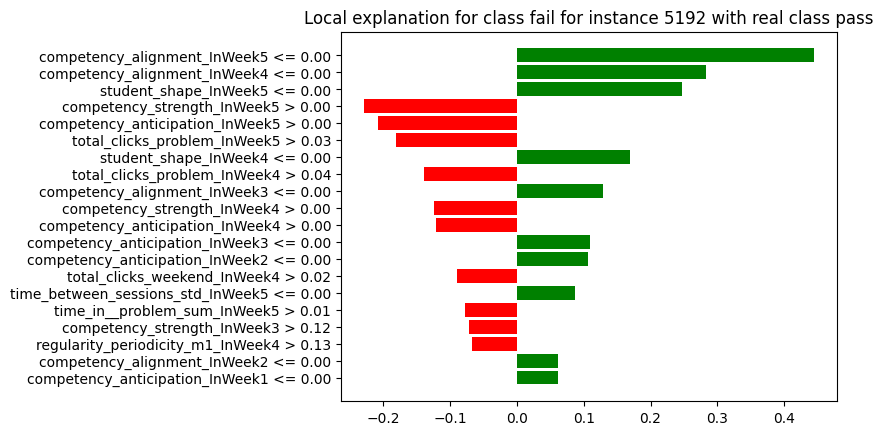

In [39]:
print('pyplot')
pyplot_all(explainers,instances,y,group)


In [40]:
print('df saving')
df,dfl=DataFrame_all(explainers,instances,y,group)

# df.iloc[:,2::] = abs(df.iloc[:,2::])
ai = np.argsort(df.iloc[:,2::].values)
for j,c in enumerate(list(ai[:,:10])):
    df.iloc[j,c+2] = np.arange(1,11)


df saving


In [41]:
df

,exp number,real value,competency_alignment_InWeek5 <= 0.00,competency_alignment_InWeek4 <= 0.00,student_shape_InWeek5 <= 0.00,competency_strength_InWeek5 > 0.00,competency_anticipation_InWeek5 > 0.00,total_clicks_problem_InWeek5 > 0.03,student_shape_InWeek4 <= 0.00,total_clicks_problem_InWeek4 > 0.04,...,competency_anticipation_InWeek4 > 0.00,competency_anticipation_InWeek3 <= 0.00,competency_anticipation_InWeek2 <= 0.00,total_clicks_weekend_InWeek4 > 0.02,time_between_sessions_std_InWeek5 <= 0.00,time_in__problem_sum_InWeek5 > 0.01,competency_strength_InWeek3 > 0.12,regularity_periodicity_m1_InWeek4 > 0.13,competency_alignment_InWeek2 <= 0.00,competency_anticipation_InWeek1 <= 0.00
0,5192,pass,0.445309,0.283772,0.247282,1.0,2.0,3.0,0.168562,4.0,...,6.0,0.109764,0.105969,7.0,0.087404,8.0,9.0,10.0,0.062058,0.061495


In [42]:
top_features = df.columns
top_features = top_features[2::]
top_features_type = np.array([s[0:s.find('InWeek')].split(' ')[-1] for s in top_features])
top_features_week = np.array([s[s.find('InWeek')+6::].split(' ')[0] for s in top_features])
count = (~(df.iloc[:,2::].isnull())).values.sum(axis=0)
top_features_type_unique = list({ k for k in top_features_type })
count_feature_type = [count[top_features_type==x].sum()/500 for x in top_features_type_unique]
top_features_week_unique = list({ k for k in top_features_week })
count_feature_week = [count[top_features_week==x].sum()/500 for x in top_features_week_unique]


/var/folders/rq/nzqjmf0x07vg4p477yrb9w800000gn/T/ipykernel_85157/172184971.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x=top_features_type_unique, y=count_feature_type, palette="rocket",ax =ax,order=np.take_along_axis(np.array(top_features_type_unique), ind, axis=0))
/var/folders/rq/nzqjmf0x07vg4p477yrb9w800000gn/T/ipykernel_85157/172184971.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


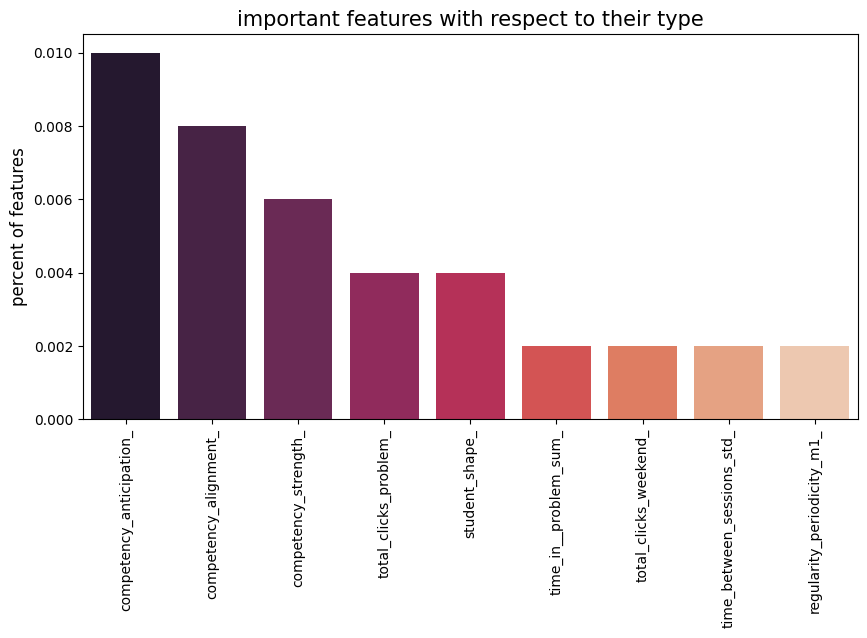

In [43]:
ind = np.argsort(count_feature_type)[::-1]
fig, ax = pyplot.subplots(figsize=(10, 5),facecolor='white')
g = sns.barplot(x=top_features_type_unique, y=count_feature_type, palette="rocket",ax =ax,order=np.take_along_axis(np.array(top_features_type_unique), ind, axis=0))
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title( 'important features with respect to their type', fontsize=15)
g.set_xlabel("", fontsize=15)
g.set_ylabel("percent of features", fontsize=12)
if not os.path.exists("./uniform_eq_results_ori/LIME/" + course + "/pyplots/"):
    os.makedirs("./uniform_eq_results_ori/LIME/" + course + "/pyplots/")
pyplot.savefig("./uniform_eq_results_ori/LIME/" + course + "/pyplots/impFeaturesType.png", bbox_inches = 'tight', facecolor=fig.get_facecolor())



/var/folders/rq/nzqjmf0x07vg4p477yrb9w800000gn/T/ipykernel_85157/1113655530.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x=top_features_week_unique, y=count_feature_week, palette="rocket",ax =ax,
/var/folders/rq/nzqjmf0x07vg4p477yrb9w800000gn/T/ipykernel_85157/1113655530.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=0)


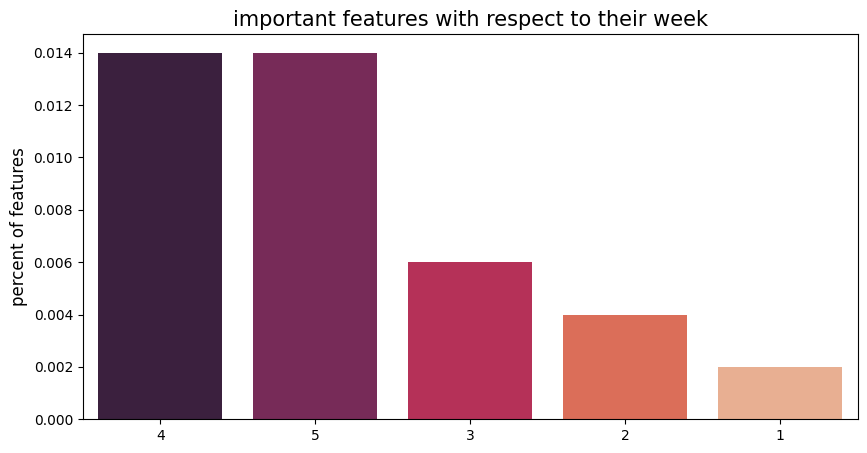

In [44]:
ind = np.argsort(count_feature_week)[::-1]
fig, ax = pyplot.subplots(figsize=(10, 5),facecolor='white')
g = sns.barplot(x=top_features_week_unique, y=count_feature_week, palette="rocket",ax =ax,
                order=np.take_along_axis(np.array(top_features_week_unique), ind, axis=0))
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.set_title( 'important features with respect to their week', fontsize=15)
g.set_xlabel("", fontsize=15)
g.set_ylabel("percent of features", fontsize=12)

if not os.path.exists("./uniform_eq_results_ori/LIME/" + course + "/pyplots/"):
    os.makedirs("./uniform_eq_results_ori/LIME/" + course + "/pyplots/")
pyplot.savefig("./uniform_eq_results_ori/LIME/" + course + "/pyplots/impFeaturesWeek.png", 
               bbox_inches = 'tight', facecolor=fig.get_facecolor())


In [45]:
zero_data = np.zeros(shape=(num_weeks,len(top_features_type_unique)))
d = pd.DataFrame(zero_data, columns=top_features_type_unique)
for i,f in enumerate(top_features_type):
    d[f][int(top_features_week[i])-1]+=count[i]
    

/var/folders/rq/nzqjmf0x07vg4p477yrb9w800000gn/T/ipykernel_85157/870079632.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  d[f][int(top_features_week[i])-1]+=count[i]


AttributeError: 'list' object has no attribute 'shape'

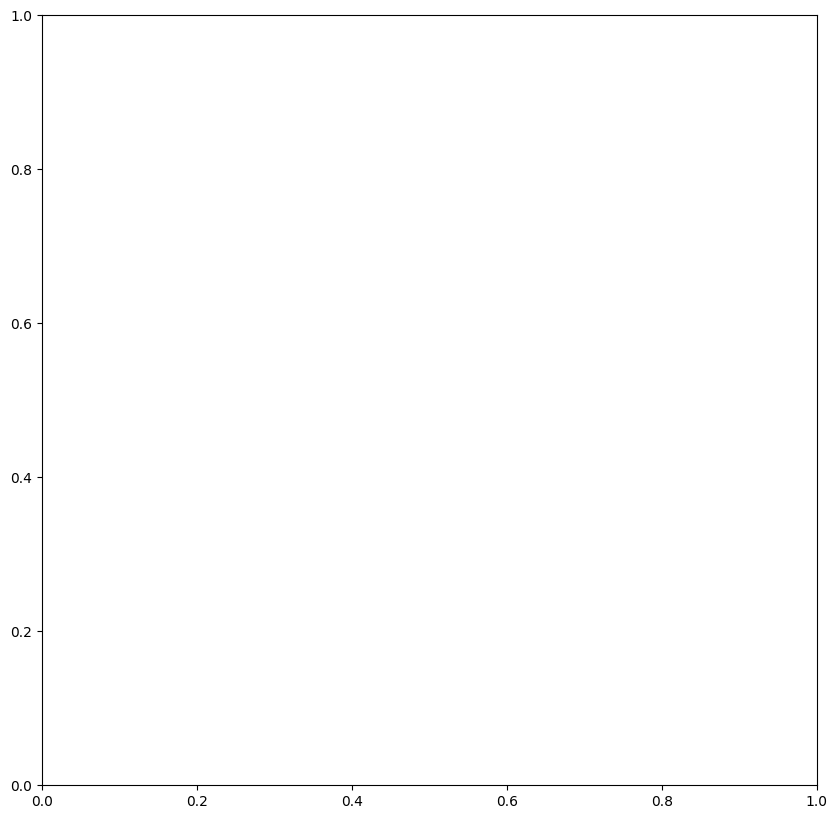

In [46]:
fig, ax = pyplot.subplots(figsize=(10, 10),facecolor='white')
g = sns.heatmap(d.values.T / instances.shape[0], annot=True, fmt=".2f",ax=ax)
l=list(np.arange(1,num_weeks+1))
g.set_xticklabels(['week'+str(i) for i in l],rotation=90)
g.set_yticklabels(top_features_type_unique,rotation=0)

if not os.path.exists("./uniform_eq_results_ori/LIME/" + course + "/pyplots/"):
    os.makedirs("./uniform_eq_results_ori/LIME/" + course + "/pyplots/")
pyplot.savefig("./uniform_eq_results_ori/LIME/" + course + "/pyplots/heatmap.png", bbox_inches = 'tight', facecolor=fig.get_facecolor())



In [47]:
if not os.path.exists("./uniform_eq_results_ori/LIME/"+course+"/dataframes/"):
    os.makedirs("./uniform_eq_results_ori/LIME/"+course+"/dataframes/")

df.to_csv(r'./uniform_eq_results_ori/LIME/'+course+'/dataframes/all_important_features.csv', index = False, header = True)
d.to_csv(r'./uniform_eq_results_ori/LIME/'+course+'/dataframes/df_for_heatmap.csv', index = False, header = True)

